# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 31, 11:59PM

### Name : Shrey Shah

### CWID : 20009523


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned hyper-parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [3]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np
import tensorflow.keras

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [4]:
def to_one_hot(y, num_class=10):
    y_new = []
    for val in y:
        tempArr = np.zeros(num_class)
        tempArr[val] = 1
        y_new.append(tempArr)
    
    return np.asarray(y_new)
    pass
    
x_train, x_test = x_train.astype('float32') / 255, x_test.astype('float32') / 255
y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [5]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(x_train,y_train_vec,test_size=0.2,shuffle=True)

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [6]:
# Build the model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [7]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers

lr = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = lr), metrics=['accuracy'])

In [8]:
# Train the model and store model parameters/loss values
model_1 = model.fit(x_tr, y_tr, batch_size=128, epochs=50, validation_data=(x_val, y_val))
model.save('model_1.h5')

Epoch 1/50
313/313 [==============================] - 7s 6ms/step - loss: 1.9130 - accuracy: 0.3328 - val_loss: 1.7204 - val_accuracy: 0.3934
Epoch 2/50
313/313 [==============================] - 1s 4ms/step - loss: 1.6476 - accuracy: 0.4212 - val_loss: 1.6346 - val_accuracy: 0.4177
Epoch 3/50
313/313 [==============================] - 2s 5ms/step - loss: 1.5266 - accuracy: 0.4651 - val_loss: 1.4741 - val_accuracy: 0.4801
Epoch 4/50
313/313 [==============================] - 1s 4ms/step - loss: 1.4451 - accuracy: 0.4913 - val_loss: 1.3970 - val_accuracy: 0.5091
Epoch 5/50
313/313 [==============================] - 1s 4ms/step - loss: 1.3866 - accuracy: 0.5149 - val_loss: 1.4378 - val_accuracy: 0.4946
Epoch 6/50
313/313 [==============================] - 1s 4ms/step - loss: 1.3395 - accuracy: 0.5310 - val_loss: 1.3207 - val_accuracy: 0.5356
Epoch 7/50
313/313 [==============================] - 1s 4ms/step - loss: 1.3000 - accuracy: 0.5486 - val_loss: 1.3296 - val_accuracy: 0.5312
Epoch 

## 3. Plot the training and validation loss curve versus epochs. (5 points)

In [9]:
model_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

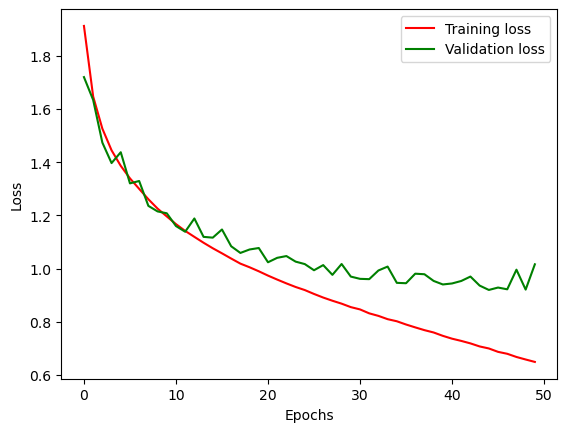

In [10]:
# Plot the loss curve

import matplotlib.pyplot as plt
#%matplotlib inline

loss = model_1.history['loss']
val_loss = model_1.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')

epochs = range(len(loss))

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'green', label='Validation loss')

plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [11]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(32, 32, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4), activation = 'relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 0.0001) , metrics=['acc'])

In [12]:
#<Train your model on the entire training set (50K samples)>
model_2 = model.fit(x_train, y_train_vec, batch_size=128, epochs=50)
model.save('model_2.h5')

Epoch 1/50
391/391 [==============================] - 2s 4ms/step - loss: 1.8399 - acc: 0.3516
Epoch 2/50
391/391 [==============================] - 1s 4ms/step - loss: 1.5559 - acc: 0.4488
Epoch 3/50
391/391 [==============================] - 1s 4ms/step - loss: 1.4341 - acc: 0.4925
Epoch 4/50
391/391 [==============================] - 1s 4ms/step - loss: 1.3553 - acc: 0.5208
Epoch 5/50
391/391 [==============================] - 1s 4ms/step - loss: 1.2973 - acc: 0.5439
Epoch 6/50
391/391 [==============================] - 1s 4ms/step - loss: 1.2485 - acc: 0.5618
Epoch 7/50
391/391 [==============================] - 1s 4ms/step - loss: 1.2071 - acc: 0.5779
Epoch 8/50
391/391 [==============================] - 1s 4ms/step - loss: 1.1724 - acc: 0.5905
Epoch 9/50
391/391 [==============================] - 1s 4ms/step - loss: 1.1408 - acc: 0.6011
Epoch 10/50
391/391 [==============================] - 1s 4ms/step - loss: 1.1099 - acc: 0.6126
Epoch 11/50
391/391 [============================

## 5. Evaluate the model on the test set (5 points)

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [13]:
from keras.models import load_model

current_model = load_model('model_1.h5')
Current_acc = current_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(Current_acc[0]))
print('accuracy = ' + str(Current_acc[1]))

313/313 [==============================] - 1s 2ms/step - loss: 1.0277 - accuracy: 0.6602
loss = 1.0277191400527954
accuracy = 0.6601999998092651


In [14]:
current_model = load_model('model_2.h5')
Current_acc = current_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(Current_acc[0]))
print('accuracy = ' + str(Current_acc[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.8680 - acc: 0.7045
loss = 0.8679858446121216
accuracy = 0.7045000195503235


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

### First Model using Batch Normalization:

In [15]:
#Building the model

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 64)      

In [16]:
# Doing data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

temp_data = ImageDataGenerator( rotation_range=20, height_shift_range=0.2, width_shift_range=0.2, zoom_range = 0.2, shear_range = 0.2, horizontal_flip=True)

In [17]:
# Define model optimizer and loss function
lr = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=lr), metrics=['acc'])

In [18]:
# Fits the model with real-time data augmentation

model_3 = model.fit(temp_data.flow(x_tr, y_tr, batch_size=128), steps_per_epoch=x_tr.shape[0] // 128, epochs=50, validation_data=(x_val, y_val), validation_batch_size=x_val.shape[0] // 40)
model.save('model_3.h5')

Epoch 1/50
312/312 [==============================] - 14s 41ms/step - loss: 1.7661 - acc: 0.3656 - val_loss: 2.4578 - val_acc: 0.1781
Epoch 2/50
312/312 [==============================] - 12s 40ms/step - loss: 1.5402 - acc: 0.4496 - val_loss: 1.3038 - val_acc: 0.5356
Epoch 3/50
312/312 [==============================] - 13s 41ms/step - loss: 1.4541 - acc: 0.4795 - val_loss: 1.3265 - val_acc: 0.5329
Epoch 4/50
312/312 [==============================] - 13s 40ms/step - loss: 1.3897 - acc: 0.5039 - val_loss: 1.3783 - val_acc: 0.5250
Epoch 5/50
312/312 [==============================] - 12s 40ms/step - loss: 1.3344 - acc: 0.5272 - val_loss: 1.3185 - val_acc: 0.5375
Epoch 6/50
312/312 [==============================] - 13s 40ms/step - loss: 1.2992 - acc: 0.5393 - val_loss: 1.1908 - val_acc: 0.5739
Epoch 7/50
312/312 [==============================] - 13s 41ms/step - loss: 1.2653 - acc: 0.5526 - val_loss: 1.1303 - val_acc: 0.6010
Epoch 8/50
312/312 [==============================] - 13s 41ms

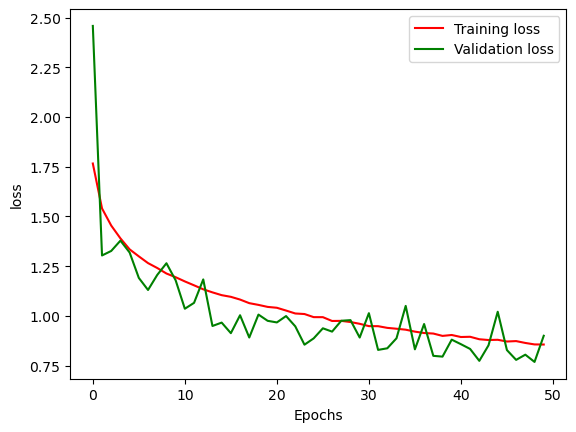

In [35]:
# Plot the loss curve

loss = model_3.history['loss']
val_loss = model_3.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('loss')

epochs = range(len(loss))

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'green', label='Validation loss')

plt.legend()
plt.show()

### Train the model on the entire training set
Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [23]:
#<Compile your model again (using the same hyper-parameters you tuned above)>

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = lr) , metrics=['acc'])

# Data augmentation

temp_data = ImageDataGenerator( rotation_range=20, height_shift_range=0.2, width_shift_range=0.2, 
                               zoom_range = 0.2, shear_range = 0.2, horizontal_flip=True)

In [24]:
model_4 = model.fit(temp_data.flow(x_train, y_train_vec, batch_size=128), steps_per_epoch=x_tr.shape[0] // 128, epochs=50)
model.save('model_4.h5')

Epoch 1/50
312/312 [==============================] - 14s 42ms/step - loss: 1.7751 - acc: 0.3651
Epoch 2/50
312/312 [==============================] - 13s 40ms/step - loss: 1.5258 - acc: 0.4496
Epoch 3/50
312/312 [==============================] - 13s 41ms/step - loss: 1.4247 - acc: 0.4872
Epoch 4/50
312/312 [==============================] - 13s 40ms/step - loss: 1.3614 - acc: 0.5133
Epoch 5/50
312/312 [==============================] - 13s 41ms/step - loss: 1.3183 - acc: 0.5304
Epoch 6/50
312/312 [==============================] - 13s 41ms/step - loss: 1.2727 - acc: 0.5475
Epoch 7/50
312/312 [==============================] - 12s 40ms/step - loss: 1.2425 - acc: 0.5579
Epoch 8/50
312/312 [==============================] - 13s 41ms/step - loss: 1.2169 - acc: 0.5675
Epoch 9/50
312/312 [==============================] - 13s 41ms/step - loss: 1.1947 - acc: 0.5772
Epoch 10/50
312/312 [==============================] - 13s 40ms/step - loss: 1.1706 - acc: 0.5853
Epoch 11/50
312/312 [========

In [22]:
# Evaluate your model performance (testing accuracy) on testing data.

current_model = load_model('model_3.h5')
current_acc = current_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(current_acc[0]))
print('accuracy = ' + str(current_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.9273 - acc: 0.6935
loss = 0.9273090958595276
accuracy = 0.6934999823570251


In [25]:
# Evaluate your model performance (testing accuracy) on testing data.

current_model = load_model('model_4.h5')
current_acc = current_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(current_acc[0]))
print('accuracy = ' + str(current_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.8667 - acc: 0.7015
loss = 0.8666813373565674
accuracy = 0.7014999985694885


### Second Model using Batch Normalization and Dropout:

In [26]:
# Build the model


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_9 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_10 (Bat  (None, 12, 12, 64)      

In [27]:
# Define model optimizer and loss function

lr = 0.001
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=lr), metrics=['acc'])

In [28]:
# Train the model and store model parameters/loss values

model_5 = model.fit(x_tr, y_tr, batch_size=128, epochs=50, validation_data=(x_val, y_val))
model.save('model_5.h5')

Epoch 1/50
313/313 [==============================] - 3s 7ms/step - loss: 1.4010 - acc: 0.5006 - val_loss: 2.7804 - val_acc: 0.2018
Epoch 2/50
313/313 [==============================] - 2s 6ms/step - loss: 1.0765 - acc: 0.6166 - val_loss: 1.2008 - val_acc: 0.5772
Epoch 3/50
313/313 [==============================] - 2s 6ms/step - loss: 0.9486 - acc: 0.6665 - val_loss: 1.0610 - val_acc: 0.6245
Epoch 4/50
313/313 [==============================] - 2s 6ms/step - loss: 0.8707 - acc: 0.6932 - val_loss: 1.4986 - val_acc: 0.4899
Epoch 5/50
313/313 [==============================] - 2s 6ms/step - loss: 0.8040 - acc: 0.7161 - val_loss: 0.9244 - val_acc: 0.6689
Epoch 6/50
313/313 [==============================] - 2s 6ms/step - loss: 0.7486 - acc: 0.7391 - val_loss: 0.9386 - val_acc: 0.6749
Epoch 7/50
313/313 [==============================] - 2s 6ms/step - loss: 0.7028 - acc: 0.7531 - val_loss: 0.8941 - val_acc: 0.6939
Epoch 8/50
313/313 [==============================] - 2s 6ms/step - loss: 0.

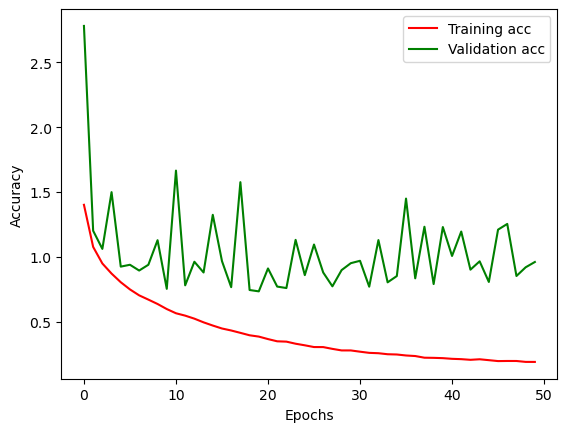

In [34]:
# Plot the loss curve

import matplotlib.pyplot as plt
%matplotlib inline

loss = model_5.history['loss']
val_loss = model_5.history['val_loss']

epochs = range(len(loss))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(epochs, loss, 'red', label='Training acc')
plt.plot(epochs, val_loss, 'green', label='Validation acc')

plt.legend()
plt.show()

### Train the model on the entire training set
Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [30]:
#<Compile your model again (using the same hyper-parameters you tuned above)>

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=lr), metrics=['acc'])

In [31]:
# Train the model and store model parameters/loss values

model_6 = model.fit(x_train, y_train_vec, batch_size=128, epochs=50)
model.save('model_6.h5')

Epoch 1/50
391/391 [==============================] - 3s 6ms/step - loss: 1.3297 - acc: 0.5261
Epoch 2/50
391/391 [==============================] - 2s 6ms/step - loss: 1.0174 - acc: 0.6375
Epoch 3/50
391/391 [==============================] - 2s 6ms/step - loss: 0.8976 - acc: 0.6840
Epoch 4/50
391/391 [==============================] - 2s 6ms/step - loss: 0.8171 - acc: 0.7147
Epoch 5/50
391/391 [==============================] - 2s 6ms/step - loss: 0.7628 - acc: 0.7312
Epoch 6/50
391/391 [==============================] - 2s 6ms/step - loss: 0.7103 - acc: 0.7508
Epoch 7/50
391/391 [==============================] - 2s 6ms/step - loss: 0.6668 - acc: 0.7684
Epoch 8/50
391/391 [==============================] - 2s 6ms/step - loss: 0.6324 - acc: 0.7792
Epoch 9/50
391/391 [==============================] - 2s 6ms/step - loss: 0.5946 - acc: 0.7924
Epoch 10/50
391/391 [==============================] - 2s 6ms/step - loss: 0.5733 - acc: 0.7995
Epoch 11/50
391/391 [============================

In [32]:
# Evaluate your model performance (testing accuracy) on testing data.

current_model = load_model('model_5.h5')
current_acc = current_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(current_acc[0]))
print('accuracy = ' + str(current_acc[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.9862 - acc: 0.7103
loss = 0.9862155318260193
accuracy = 0.7103000283241272


In [33]:
# Evaluate your model performance (testing accuracy) on testing data.

current_model = load_model('model_6.h5')
current_acc = current_model.evaluate(x_test, y_test_vec)
print('loss = ' + str(current_acc[0]))
print('accuracy = ' + str(current_acc[1]))

313/313 [==============================] - 1s 2ms/step - loss: 1.1104 - acc: 0.7182
loss = 1.1104212999343872
accuracy = 0.7182000279426575


## Comparision and Analysis:

*Normal CNN model:* is not that efficient and has an accuracy of 66 % and after using full training dataset it achieves accuracy of 70 %. *My first model* which uses data augmentation and batch normalization has a accuracy of 69 % and after using full training dataset it achieves has accuracy of 70 %. *My second and final model* which uses batch normaliztion and dropout has an accuracy of 71 % and after using full training dataset it achieves an accuracy of ~72 %.

In [36]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()